In [1]:
# Need to use 'YOLO_v3_Labelling_Tool'
# https://medium.com/analytics-vidhya/training-yolo-with-keras-85c33cdefe21
# https://github.com/qqwweee/keras-yolo3
# https://github.com/developer0hye/Yolo_Label

log_dir = './output/' # 폴더 미리 생성할것 (폴더생성 권한문제로 오류날 수 있음)
annotation_path = './yolo_train.txt'
classes_path = './yolo_classes.txt'
anchors_path = './yolo_anchors.txt'

import sys
sys.path.append("./")

import numpy as np
import keras.backend as K
from keras.layers import Input, Lambda
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from yolo3_model import preprocess_true_boxes, yolo_body, tiny_yolo_body, yolo_loss
from yolo3_utils import get_random_data

def create_model(input_shape, anchors, num_classes, load_pretrained=True,
freeze_body=1, weights_path='yolo3_weights_via_MSCOCO.h5'): # Full filtering
#freeze_body=2, weights_path='yolo3_weights_via_MSCOCO.h5'):
    K.clear_session() # get a new session
    image_input = Input(shape=(None, None, 3))
    h, w = input_shape
    num_anchors = len(anchors)

    y_true = [Input(shape=(h//{0:32, 1:16, 2:8}[l], w//{0:32, 1:16, 2:8}[l], \
        num_anchors//3, num_classes+5)) for l in range(3)]

    model_body = yolo_body(image_input, num_anchors//3, num_classes)
    print('Create YOLOv3 model with {} anchors and {} classes.'.format(num_anchors, num_classes))

    if load_pretrained:
        model_body.load_weights(weights_path, by_name=True, skip_mismatch=True)
        print('Load weights {}.'.format(weights_path))
        if freeze_body in [1, 2]:
            # Freeze darknet53 body or freeze all but 3 output layers.
            num = (185, len(model_body.layers)-3)[freeze_body-1]
            for i in range(num): model_body.layers[i].trainable = False
            print('Freeze the first {} layers of total {} layers.'.format(num, len(model_body.layers)))

    model_loss = Lambda(yolo_loss, output_shape=(1,), name='yolo_loss',
        arguments={'anchors': anchors, 'num_classes': num_classes, 'ignore_thresh': 0.5})(
        [*model_body.output, *y_true])
    model = Model([model_body.input, *y_true], model_loss)

    return model

def data_generator(annotation_lines, batch_size, input_shape, anchors, num_classes):
    '''data generator for fit_generator'''
    n = len(annotation_lines)
    i = 0
    while True:
        image_data = []
        box_data = []
        for b in range(batch_size):
            if i==0:
                np.random.shuffle(annotation_lines)
            image, box = get_random_data(annotation_lines[i], input_shape, random=True)
            image_data.append(image)
            box_data.append(box)
            i = (i+1) % n
        image_data = np.array(image_data)
        box_data = np.array(box_data)
        y_true = preprocess_true_boxes(box_data, input_shape, anchors, num_classes)
        yield [image_data, *y_true], np.zeros(batch_size)

def data_generator_wrapper(annotation_lines, batch_size, input_shape, anchors, num_classes):
    n = len(annotation_lines)
    if n==0 or batch_size<=0: return None
    return data_generator(annotation_lines, batch_size, input_shape, anchors, num_classes)


def get_classes(classes_path):
    with open(classes_path) as f:
        class_names = f.readlines()
    class_names = [c.strip() for c in class_names]
    return class_names

def get_anchors(anchors_path):
    with open(anchors_path) as f:
        anchors = f.readline()
    anchors = [float(x) for x in anchors.split(',')]
    return np.array(anchors).reshape(-1, 2)

class_names = get_classes(classes_path)
num_classes = len(class_names)
anchors = get_anchors(anchors_path)

input_shape = (416,416) # multiple of 32, hw

# make sure you know what you freeze
model = create_model(input_shape, anchors, num_classes, freeze_body=1, weights_path='yolo3_weights_via_MSCOCO.h5')
#model = create_model(input_shape, anchors, num_classes, freeze_body=2, weights_path='yolo3_weights_via_MSCOCO.h5')

logging = TensorBoard(log_dir=log_dir)
checkpoint = ModelCheckpoint(log_dir + 'ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5',
    monitor='val_loss', save_weights_only=True, save_best_only=True, save_freq=3)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1)

val_split = 0.1
with open(annotation_path) as f:
    lines = f.readlines()
np.random.seed(10101)
np.random.shuffle(lines)
np.random.seed(None)
num_val = int(len(lines)*val_split)
num_train = len(lines) - num_val

2023-02-02 06:46:21.010970: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-02 06:46:21.158896: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-02 06:46:21.158914: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-02-02 06:46:21.769898: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directo

Create YOLOv3 model with 9 anchors and 1 classes.
Load weights yolo3_weights_via_MSCOCO.h5.
Freeze the first 185 layers of total 252 layers.


In [3]:
model.compile(optimizer=Adam(), loss={ # Removing learning_rate because of gradient explosion
    # use custom yolo_loss Lambda layer.
    'yolo_loss': lambda y_true, y_pred: y_pred})

batch_size = 32
print('Train on {} samples, val on {} samples, with batch size {}.'.format(num_train, num_val, batch_size))

history = model.fit(data_generator_wrapper(lines[:num_train], batch_size, input_shape, anchors, num_classes),
        steps_per_epoch=max(1, num_train//batch_size),
        validation_data=data_generator_wrapper(lines[num_train:], batch_size, input_shape, anchors, num_classes),
        validation_steps=max(1, num_val//batch_size),
        epochs=100,
        initial_epoch=0,
        verbose=1)

model.save_weights(log_dir + 'yolo3_weights_trained_1910_epoch_100.h5')

Train on 1719 samples, val on 191 samples, with batch size 32.
Epoch 1/100
Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


2023-02-02 06:46:54.016566: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Subshape must have computed start >= end since stride is negative, but is 0 and 2 (computed from start 0 and end 9223372036854775807 over shape with rank 2 and stride-1)


53/53 [==============================] - ETA: 0s - loss: 615.8973 

2023-02-02 06:56:39.702476: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Subshape must have computed start >= end since stride is negative, but is 0 and 2 (computed from start 0 and end 9223372036854775807 over shape with rank 2 and stride-1)


53/53 [==============================] - 625s 12s/step - loss: 615.8973 - val_loss: 538.8405
Epoch 2/100
53/53 [==============================] - 613s 12s/step - loss: 40.8916 - val_loss: 114.1678
Epoch 3/100
53/53 [==============================] - 615s 12s/step - loss: 30.6731 - val_loss: 35.8278
Epoch 4/100
53/53 [==============================] - 612s 12s/step - loss: 25.6489 - val_loss: 26.6883
Epoch 5/100
53/53 [==============================] - 613s 12s/step - loss: 22.5645 - val_loss: 23.0477
Epoch 6/100
53/53 [==============================] - 615s 12s/step - loss: 20.4731 - val_loss: 20.5594
Epoch 7/100
53/53 [==============================] - 614s 12s/step - loss: 19.0568 - val_loss: 19.2550
Epoch 8/100
53/53 [==============================] - 613s 12s/step - loss: 18.0858 - val_loss: 18.1876
Epoch 9/100
53/53 [==============================] - 612s 12s/step - loss: 17.4744 - val_loss: 17.5005
Epoch 10/100
53/53 [==============================] - 613s 12s/step - loss: 16.813

Epoch 80/100
53/53 [==============================] - 614s 12s/step - loss: 11.7436 - val_loss: 12.5992
Epoch 81/100
53/53 [==============================] - 617s 12s/step - loss: 11.7267 - val_loss: 12.4299
Epoch 82/100
53/53 [==============================] - 613s 12s/step - loss: 11.7339 - val_loss: 12.0873
Epoch 83/100
53/53 [==============================] - 611s 12s/step - loss: 11.7277 - val_loss: 12.9760
Epoch 84/100
53/53 [==============================] - 613s 12s/step - loss: 11.7575 - val_loss: 12.0321
Epoch 85/100
53/53 [==============================] - 612s 12s/step - loss: 11.6297 - val_loss: 11.8464
Epoch 86/100
53/53 [==============================] - 613s 12s/step - loss: 11.5333 - val_loss: 12.4874
Epoch 87/100
53/53 [==============================] - 612s 12s/step - loss: 11.6258 - val_loss: 12.1598
Epoch 88/100
53/53 [==============================] - 612s 12s/step - loss: 11.6126 - val_loss: 11.9761
Epoch 89/100
53/53 [==============================] - 612s 12s/s

dict_keys(['loss', 'val_loss'])


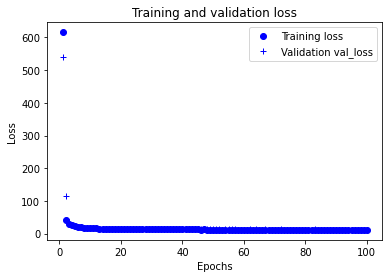

In [4]:
# dataset=1910, freeze=1, epochs=100

import matplotlib.pyplot as plt

print(history.history.keys())
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

# bo = 파란색 점
plt.plot(epochs, loss, 'bo', label='Training loss') # plot x and y using blue circle markers
# b = 파란색 실선
plt.plot(epochs, val_loss, 'b+', label='Validation val_loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

dict_keys(['loss', 'val_loss'])


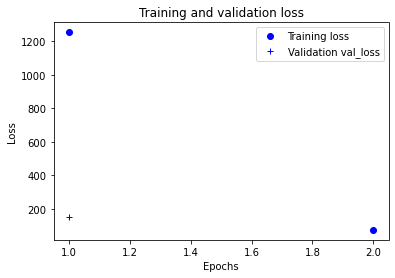

In [4]:
# dataset=1910, freeze=1, epochs=10 (Gradient Explosion)

import matplotlib.pyplot as plt

print(history.history.keys())
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

# bo = 파란색 점
plt.plot(epochs, loss, 'bo', label='Training loss') # plot x and y using blue circle markers
# b = 파란색 실선
plt.plot(epochs, val_loss, 'b+', label='Validation val_loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

dict_keys(['loss', 'val_loss'])


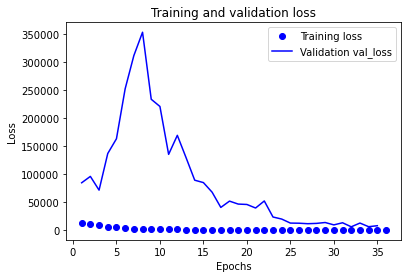

In [4]:
# dataset=20, freeze=1, epochs=100

import matplotlib.pyplot as plt

print(history.history.keys())
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

# bo = 파란색 점
plt.plot(epochs, loss, 'bo', label='Training loss') # plot x and y using blue circle markers
# b = 파란색 실선
plt.plot(epochs, val_loss, 'b', label='Validation val_loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()